# 15 Image recognition

Part of ["Introduction to Data Science" course](https://github.com/kupav/data-sc-intro) by Pavel Kuptsov, [kupav@mail.ru](mailto:kupav@mail.ru)

Recommended reading for this section:

1. Grus, J. (2019). Data Science From Scratch: First Principles with Python (Vol. Second edition). Sebastopol, CA: O’Reilly Media

1. Understanding binary cross-entropy / log loss: a visual explanation. 
https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a

1. A Comprehensive Guide to Convolutional Neural Networks.
https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53

1. Dropout on convolutional layers is weird. 
https://towardsdatascience.com/dropout-on-convolutional-layers-is-weird-5c6ab14f19b2

The following Python modules will be required. Make sure that you have them installed.
- `matplotlib`
- `requests`
- `numpy`
- `io`
- `pathlib`
- `tensorflow`

## Lesson 1

### Required initialization and helper functions

Before we begin some initialization is required

In [ ]:
import tensorflow as tf

# This initialization code is required due to an error 
# "NotFoundError: No algorithm worked"
# when using Conv2D
# Probabliy due to problems with cuda 11.
# Remove this when fixed
# https://github.com/tensorflow/tensorflow/issues/43174
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

The function `plot_hist` below plots learning curves: loss and accuracy vs. epoch of training.

It accepts a lits of training histories `hist_list` computed for different networks and plots them as row of images.

In [ ]:
import matplotlib.pyplot as plt

def plot_hist_one(hist, name, axs):
    """Plot one loss and accuracy"""
    epochs = len(hist.history['loss'])
    xs = list(range(epochs))
    
    ax = axs[0]
    ax.plot(xs, hist.history['loss'], label='loss')
    ax.plot(xs, hist.history['val_loss'], label='val_loss')
    ax.set_ylabel('loss')
    ax.set_yscale('log')

    ax = axs[1]
    ax.plot(xs, hist.history['accuracy'], label='accuracy');
    ax.plot(xs, hist.history['val_accuracy'], label='val_accuracy');
    ax.set_ylabel('accuracy')

    for ax in axs:
        ax.grid()
        ax.set_xlabel('epoch')
        ax.legend(title=name)    

def plot_hist(hist_list, hist_names):
    """Plot loss and accuracy for many network"""
    N = len(hist_list)
    fig, axs = plt.subplots(nrows=N, ncols=2, figsize=(10, 3*N))
    if N == 1:
        axs = [axs]
    for hist, name, ax in zip(hist_list, hist_names, axs):
        plot_hist_one(hist, name, ax)
    plt.tight_layout()

### Image from the point of view of computer

Gray scale image is a two dimensional array. 

Each cell of the array corresponds to an image pixel.

Values encode gray level. 

Typically each pixel is encoded by one byte. 

Let us remember that a byte includes 8 bits and hence can hold integers from 0 to 255. 

Bytes is represented by the `numpy` type `np.uint8`.

So a gray scale is a two dimensional array of integers of type `np.uint8`. Each between 0 and 255: 0 is black and 255 is white.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

im1 = np.zeros((3, 3), dtype=np.uint8)

im1[1, 1] = 255
im1[0, 1] = 255
im1[1, 0] = 255
im1[2, 1] = 255
im1[1, 2] = 255

print(im1)

An image can be shown with `matplotlib` function `imshow`:

In [ ]:
fig, ax = plt.subplots()
ax.imshow(im1, cmap='gray');

When an image planned to be processed with a neural network, it is usually converted to a float type where values are between 0 and 1.

`Matplotlib` still can plot rescaled image since it detects the scale automatically.

In [ ]:
im2 = im1 / 256.0
print(im2)

fig, ax = plt.subplots()
ax.imshow(im2, cmap='gray');

Pixels of an image are enumerated from the top left angle. First goes vertical coordinate, i.e., height, and the second is width.

In the example below we create an image with 17 pixels of heights and 5 of width. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

im3 = np.zeros((17, 5), dtype=np.uint8)

cnt = 0
for y in range(17):
    for x in range(5):
        if y % 5 == x: 
            cnt += 1
            im3[y, x] = cnt

print(im3)

fig, ax = plt.subplots(figsize = (2, 16))
ax.imshow(im3, cmap='gray');

If we store an image as a numpy array its sizes can be obtained via `.shape` attribute.

In [ ]:
print(im3.shape)

Colors on a computer screen are formed as a mixture of several channels. 

One of the popular encoding scheme is RGB: each pixel is encoded by three bytes, i.e., integers each between 0 and 255.

The RGB color image can be considered as a stack of three gray scaled images. Each layer encodes intensities of red, green and blue colors.

Totally a color image is represented in a computer memory as a three dimensional array

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

im4 = np.zeros((32, 32, 3), dtype=np.uint8)
size_y, size_x, _ = im4.shape

# Red channel - intensity grows vertically
cnt = 0 
for y in range(size_y):
    for x in range(size_x):
        im4[y, x, 0] = cnt
        cnt = (cnt + 1) % 256

# Green channel - intensity grows horizontally
cnt = 0
for x in range(size_x):
    for y in range(size_y):
        im4[y, x, 1] = cnt
        cnt = (cnt + 1) % 256
        
# Blue channel - along diagonals
cnt = 0
for s in range(0, size_x + size_y - 1):
    for x in range(max(0, s - (size_y - 1)), min(s + 1, size_x)):
        y = s - x
        im4[y, x, 2] = cnt
        cnt = (cnt + 1) % 256
        
print("Image sizes: ", im4.shape)        

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
axs[0].imshow(im4[:,:,0], cmap='gray')
axs[1].imshow(im4[:,:,1], cmap='gray')
axs[2].imshow(im4[:,:,2], cmap='gray')
axs[3].imshow(im4);

Also a transparency can be taken into account. Then in addition to those one more channel appears that is called alpha-channel. 

Zero means full transparency and 255 is non-transparent.

There are many other ways to encode colors. They are called color models: HSV, LAB and so on.

### Binary cross entropy

Previously we considered two class classification. The network had a single output neuron with step function or sigmoid as an activation function. 

The result was a value $0\leq q\leq 1$ that was compared with the true value $p$ which was either exact $0$ or $1$. 

The lose function was the mean squared error:

$$
\text{MSE} = \frac{1}{N}\sum_{i=1}^N (p_i - q_i)^2
$$

Although it seams to be intuitively obvious, the means square error is not the beast loss function for classification.

Usually a cross entropy is used instead. 

Let us remember it.

We still discuss binary prediction, i.e., there are two classes, 0 and 1.

The network output $q$ can be treated as a probability that a certain data sample belongs to the class 1. 

So we have a probability distribution: the sample belongs to the class 1 with the probability $q$ and to the class 0 with the probability $(1-q)$.

Also we have true probability distribution: class 1 has probability $p$ and class 0 - $(1-p)$. Let us not forget that $p$ can be either 1 or 0.

The cross entropy is a function that compare two probability distributions and shows how different they are. 

For the binary case it is called binary cross entropy and reads:

$$
H_p(q) = -p\log q - (1-p)\log(1-q)
$$

Let us consider a data sample whose true class is $p=1$ and the network has predicted it with the probability $q$. 

The loss function must be zero if $q=1$ and it must grow when $q<1$. 

In this case the training routine will try to make $q$ closer to 1.

And if the network predicts $q$ very close to 0, i.e., operates totally incorrect the penalty must be rely huge.

Let us compare the penalties for incorrect predictions produced by MSE and by binary cross entropy.

For MSE when $p=1$ the deviation from the true value is

$$
P_\text{MSE}=(1-q)^2
$$

And for the cross entropy we have:

$$
P_\text{BCE}=-\log q
$$

Let us plot the graphs and compare the penalties:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

q = np.linspace(1e-5, 1-1e-5, 100)
penalty_mse = (1-q)**2
penalty_log = -np.log(q)

fig, ax = plt.subplots()
ax.plot(q, penalty_mse, label="MSE")
ax.plot(q, penalty_log, label="Binary cross entropy")
ax.grid()
ax.legend();

We see very clear that the binary cross entropy provide better penalties for incorrect predictions.

That is why cross entropy is typically used as a loss function when a network is trained as a classifier.

### Simple example: handwritten numbers 0 and 1

We are going to create a very simple network that is able to recognize handwritten digits 0 and 1.

To train the network we will use a part of MNIST dataset.

The MNIST dataset (Modified National Institute of Standards and Technology dataset) is a large set of handwritten digits that is commonly used for training various image processing systems.

The MNIST dataset contains 60000 training images and 10000 testing images. Each one is a grayscale image of the size 28 x 28 pixels.

The MINST dataset is in fact standard for studying machine learning methods. 

Tensorflow provides a function `.mnist.load_data()` for downloading and opening of a copy of this dataset.

When this function is called for the first time the dataset is downloaded to a local default directory.

Under Linux and macOS this is `$HOME/.keras/` and in Windows this is `%USERPROFILE%\.keras\`

Next calls of this function results in just opening of the dataset.

In [ ]:
# Returns tuple of numpy arrays: (x_train, y_train), (x_test, y_test)
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
print("Image labels example: ", y_train[:20])

At the moment we will consider only two classes so that we will extract images labeled as `0` or `1`.

In [ ]:
import numpy as np

def extract01(X_data, y_data):
    """Extract images with 0 or 1 only"""
    X_data01 = []
    y_data01 = []
    for X, y in zip(X_data, y_data):
        if y <= 1:
            X_data01.append(X)
            y_data01.append(y)
    return np.array(X_data01), np.array(y_data01)

X_train01, y_train01 = extract01(X_train, y_train)
X_test01, y_test01 = extract01(X_test, y_test)

print("train ", X_train01.shape)
print("test ", X_test01.shape)

Let us see what we have: below there is a plot of several images from the dataset.

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=10, ncols=16)

for ax, X, y in zip(axs.reshape(-1), X_train01, y_train01):
    ax.imshow(X, cmap='gray_r')
    ax.axis("off")
    
plt.tight_layout()

Let us check the balance.

Inspecting histograms of labels we see that the all classes appears with almost equal frequencies.

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axs[0].hist(y_train01, bins=2, rwidth=0.8)
axs[1].hist(y_test01, bins=2, rwidth=0.8);

Now we a ready to create a model. Observe that we are going to feed a network with a batch of gray scale images. This is a three dimensional array `[batch_size, image_height, image_width]` of 8 bit unsigned integers.

In [ ]:
print("Batch shape: ", X_train01.shape, "\nBatch type: ", X_train01.dtype)

But the dense layers that we are going to use accepts two dimensional batches. 

We need to rearrange two dimensional images into flat one dimensional arrays: `[batch_size, image_height * image_width]`. 

This is done by adding a layer `Flatten` to the network.

Also let us recall that all machine learning models usually perform better when we feed them with standardized data. 

For this purpose we add a `Lambda` layer where a rescaling of data is performed.

The network itself is as simple as possible. It has two dense layers, the hidden and the output one. The hidden layer has only 2 neurons. 

The output layer has one neuron because a binary prediction is performed.

Its activation is not specified and the loss function has a parameter `from_logits=True`. It means that the last activation is computed together with the loss function. 

This is because such organization of the computations produces smaller numerical errors.

Here and everywhere below we use `Adam` optimizer. 

In [ ]:
input_shape = X_train01.shape[1:]

model_mnist01 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda data: data / 256.0, input_shape=input_shape),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation='sigmoid'),
    tf.keras.layers.Dense(1) 
])

model_mnist01.compile(optimizer=tf.keras.optimizers.Adam(),  
                      loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                      metrics=['accuracy'])

model_mnist01.summary()

Observe that we specify an input shape of the first layer of the network. This is the shape of a single data record, i.e., `(28, 28)` not the shape of the whole batch.

This is not necessary but it allows print a network summary without its evaluations.

If the input shape is not specified, the model does not know how many inputs a network has so that the neurons are actually created only at the first model evaluation. 

If we want to see a model summary before its using we have to specify the shape of an input tensor.

Let us start the training.

In [ ]:
hist_mnist01 = model_mnist01.fit(X_train01, y_train01, epochs=50, validation_split=0.2, verbose=2)

Here are the learning curves. 

We see that the model trains very fast and attains almost 100\% accuracy. 

In [ ]:
plot_hist([hist_mnist01], ["mnist01"])

This is evaluation on the test data. The performance is pretty good.

In [ ]:
loss, acc = model_mnist01.evaluate(X_test01, y_test01)
print(f"acc={acc}, loss={loss}")

But nevertheless notice the overfitting: loss function for training data continues to decay in the right part of the plots while the loss function computed for the validation data saturates.

In this particular case this overfitting is not a problem since it appears when the very high accuracy is attained even for the validation and test data.

Let us finally inspect visually a quality of prediction.

Here the prediction computed for the test data. Observe that the result is a tensor of floats. Negative values correspond to 0 and the positive ones are for 1.

To use the prediction we convert the tensor to the numpy array

In [ ]:
y_pred = model_mnist01(X_test01, training=False)
print("y_pred tensor=", y_pred, "\n\ny_pred numpy=", y_pred.numpy())

Now we plot several images as well as the predicted values. We observe that the prediction is very good.

In [ ]:
fig, axs = plt.subplots(nrows=8, ncols=8, figsize=(10, 10))

for ax, X, y in zip(axs.ravel(), X_test01, y_pred.numpy()):
    ax.imshow(X, cmap='gray_r')
    ax.set_title(f"{0 if y[0] < 0 else 1}")
    ax.axis("off")
    
plt.tight_layout()

Almost perfect result with a very simple network is explained by a very simple dataset. 

It appears to be very easy to distinguish handwritten zeros and ones. 

### Argmax and softmax functions for multiclass prediction

If a network performs binary classification it typically has a single output neuron with the sigmoid activation and the binary cross entropy is used as a loss function. 

For a multiclass prediction a number output neurons must be equal to the number of classes. 

Each neuron corresponds to a particular class. 

The predicted class is that one whose neuron produces the largest output.

Thus given the logits (let us remember that the logits are raw neuron outputs without activation function) we have to find an index of the largest one. That will be the predicted class.

If we have $N$ classes and $y_i$, $i\in [0, N-1]$, are network logits the predicted class number $i_\text{pred}$ can be written mathematically as follows:

$$
i_\text{pred} = \mathop{\mathrm{argmax}}_{i\in[0,N-1]} y_i
$$

This notation means that we consider all $y_i$, find the larges and return its index $i$.

But this procedure is used when the network is already trained. 

This can not be used as the network activation as a part of the loss function because it can not differentiated.

Instead its smooth analog is used called softmax function. 

Softmax is a vector function whose numbers of elements is the same as the number classes. 

Its element for the class $k$ reads:

$$
q_k = \frac{e^{y_k}}{\sum_{i=0}^{N-1} e^{y_i}}
$$

It can be proven that $q_j$ is the largest if and only if the corresponding $y_k$ is the largest. 

Set of all $q_k$, $k=0,1,\ldots,N-1$ can be considered as a probability distribution because $q_k\in [0,1]$ and 

$$
\sum_{k=0}^{N-1} q_k=1
$$

Thus we can say that the network computes probabilities that a given data sample belong to each class. The predicted class has the larges probability.

When training we compare this probabilities with the true distribution $p_k$ where all classes has zeros and only the one has probability 1 (Let us remember: this is called one-hot representation of class labels).

This comparison is done via cross entropy that plays a role of the loss function:

$$
H_p(q) = -\sum_{i=0}^{N-1} p_i \log q_i
$$

Thus typical rules for multiclass prediction ($N$ is a number of classes):
- the network has $N$ output neurons
- the output layers is used without activations
- the loss function is cross entropy with logits (computation of the softmax is done simultaneously with the cross entropy 
for better numerical performance)
- when we do predictions we apply argmax function to the output vector of the network

### ReLU as an activation function

There are many other functions that can be used as activations in deep networks. 

Sometimes better performance can be achieved when instead of sigmoid Rectified Linear Unit is used on hidden layers.

$$
\mathop{\mathrm{ReLU}}(y) = \mathop{\mathrm{max}}(0, y)
$$

This is zero when $y\leq 0$ and it returns $y$ when $y>0$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

xs = tf.constant(np.linspace(-5, 5, 100), dtype = tf.float32)
ys1 = tf.keras.activations.sigmoid(xs)
ys2 = tf.keras.activations.relu(xs)

fig, ax = plt.subplots()

ax.plot(xs.numpy(), ys1.numpy(), label='sigmoid')
ax.plot(xs.numpy(), ys2.numpy(), label='relu')
ax.set_ylim([0, 3])
ax.legend()
ax.grid()

### Handwritten digits form 0 to 9

Let us consider prediction of all digits from the dataset MNIST

In [ ]:
# Returns tuple of numpy arrays: (x_train, y_train), (x_test, y_test)
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
print("Image labels example: ", y_train[:20])

According to the discussion above our network will compute probabilities that an image belongs to each class. 

Thus the true class labels must also be converted into a probability distributions where correct class has probability 1 and other has probability 0. 

This is called one-hot representation.

In [ ]:
import numpy as np

def onehot(y_labels, size):
    y_onehot = np.zeros((y_labels.shape[0], size))
    for ylb, yoh in zip(y_labels, y_onehot):
        yoh[ylb] = 1
    return y_onehot

# This is just an example how it works
y_onehot = onehot(y_train[:15], 10)
for ylb, yoh in zip(y_train[:15], y_onehot):
    print(ylb, yoh)

Actually such function already exists in `tensorflow`. This is called `.to_categorical`. Below we will use it.

This function can fined the number of classes automatically so it can be used with only one parameter.

In [ ]:
from tensorflow.keras.utils import to_categorical as to_categ

y_onehot = to_categ(y_train[:15], 10)
for ylb, yoh in zip(y_train[:15], y_onehot):
    print(ylb, yoh)

Let us see what we have: below there is a plot of several images from the dataset.

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=10, ncols=16)

for ax, X, y in zip(axs.reshape(-1), X_train, y_train):
    ax.imshow(X, cmap='gray_r')
    ax.axis("off")
    
plt.tight_layout()

Inspecting histograms of labels we see that the dataset is well balanced: all classes appears with almost equal frequencies.

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axs[0].hist(y_train, bins=10, rwidth=0.8)
axs[1].hist(y_test, bins=10, rwidth=0.8);

Building the model we rescale data to fit the unit range $[0,1]$ and rearrange two dimensional images to flat arrays.

The output layer has 10 neurons.

The output activation is not specified and the loss function has a parameter `from_logits=True`. It means that the last activation, softmax is assumed, will be computed together with the loss function.

The loss function is called `CategoricalCrossentropy` that corresponds to the cross entropy discussed above.

We will consider two models. The model A is the simplest:

In [ ]:
input_shape = X_train.shape[1:]

model_mnist_A = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda data: data / 256.0, input_shape=input_shape),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='sigmoid'),
    tf.keras.layers.Dense(10) 
])

model_mnist_A.compile(optimizer=tf.keras.optimizers.Adam(),  
                      loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])

model_mnist_A.summary()

And the model B is more sophisticated. This is a deep model including 5 dense layers. 

The hidden layers use ReLU instead of the sigmoid. 

Experiments show that this activation performs better.  

In [ ]:
input_shape = X_train.shape[1:]

model_mnist_B = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda data: data / 256.0, input_shape=input_shape),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(10) 
])

model_mnist_B.compile(optimizer=tf.keras.optimizers.Adam(),  
                      loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])

model_mnist_B.summary()

In [ ]:
hist_mnist_A = model_mnist_A.fit(X_train, to_categ(y_train), epochs=50, validation_split=0.2, verbose=2)

In [ ]:
hist_mnist_B = model_mnist_B.fit(X_train, to_categ(y_train), epochs=50, validation_split=0.2, verbose=2)

In [ ]:
plot_hist([hist_mnist_A, hist_mnist_B], ["mnist A", "mnist B"])

This is the evaluation on the test data.

In [ ]:
loss, acc = model_mnist_A.evaluate(X_test, to_categ(y_test))
print(f"acc={acc}, loss={loss}")

In [ ]:
loss, acc = model_mnist_B.evaluate(X_test, to_categ(y_test))
print(f"acc={acc}, loss={loss}")

It could look good. But in fact we have moderate performance. 

Predicting MNIST is a sort of competition. The leaders demonstrate accuracy above 99\%: https://en.wikipedia.org/wiki/MNIST_database

Of course we could further improve performance if continue training. We did only 50 epochs which is very small. 

The important point that is interesting for us is the overfitting.

Model A has smaller number of neurons. It means its information capacity is lower.

We observe that it has lower overfitting and also lower accuracy.

If we increase the number if neurons, model B, we obtain a better performance and also the overfitting becomes more pronounced.

Below we discuss a standard method to fight the overfitting in deep networks.

But before let us see how the prediction works.

Let us remember: our network returns logits, i.e., a floating point numbers.

To obtain the predictions we need to apply $\text{argmax}$ function to the outputs. 

The predicted class corresponds to the largest value.

In [ ]:
y_logits = model_mnist_B(X_test, training=False)
print(y_logits[:3])

In [ ]:
y_pred = tf.math.argmax(y_logits, axis=1).numpy()
print(y_pred[:3])

In [ ]:
fig, axs = plt.subplots(nrows=8, ncols=8, figsize=(10, 10))

for ax, X, y in zip(axs.ravel(), X_test, y_pred):
    ax.imshow(X, cmap='gray_r')
    ax.set_title(f"{y}")
    ax.axis("off")
    
plt.tight_layout()

### Fighting overfitting with dropout 

During the training different parts of a network can become fit for each other very much. 

It results in overfitting when the model just becomes very well adopted for training data and can not draw generalizations.

The idea of the dropout is to reconfigure the network structure before each training step. 

This is done by switching off neurons at random with the probability $p$.

Figure below show dense layers of a network before any dropouts.

![dropout_before.png](fig/dropout_before.png)
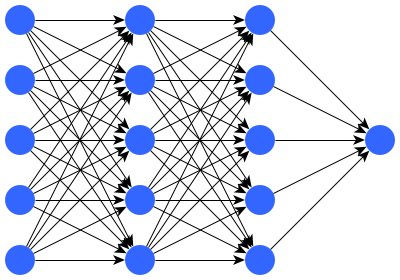

And this figure shows a particular configuration that appears after random dropping out of certain neurons.

![dropout_after.png](fig/dropout_after.png)
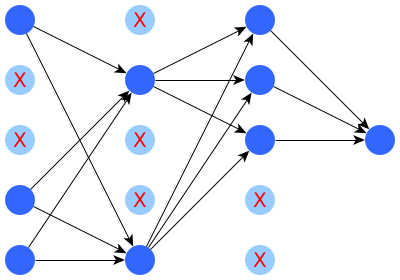

Assume that we have a neuron $k$ that takes a vector of inputs $x$, weights $W$ and biases $b$: 

$$
y_k = \sigma(x W + b)
$$

This neuron is a part of a layer of neurons so that $k$ runs from 1 to $K$ where $K$ is the layer size.

When the dropout is applied each neuron output is multiplied by a random number $d_k$:

$$
y_k = d_k \sigma(x W + b)
$$

This $d_k$ is set to $1$ with the probability $p$ and $0$ with the probability $(1-p)$.

This random numbers are computed before each training step that includes computation of gradients and updating weights. 

Weights and biases of neurons that are dropped out at the current step are not updated.

At the next training step new random $d_k$ are computed so that other neurons are dropped out.

Training with dropouts can be considered as training of an ensemble of networks.

When the network is used for prediction the dropout is switched off and the we obtained the averaged result from this ensemble.

Let us now check how dropout works. Using `tensorflow` with `keras` we just add a layers `Droput`. 

Its parameter `rate` specifies the probability of removing neurons.

There different ways to add the Dropout layers. One can add only one such layer with large rate of dropping or one can add dropouts after each layer of neurons. In this case the dropout rate should not be so large.

Below we take a model B and add a dropout layers after each dense layer with small rate.

In [ ]:
input_shape = X_train.shape[1:]

dropout_rate = 0.015

model_mnist_C = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda data: data / 256.0, input_shape=input_shape),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='relu'), tf.keras.layers.Dropout(rate=dropout_rate),
    tf.keras.layers.Dense(30, activation='relu'), tf.keras.layers.Dropout(rate=dropout_rate),
    tf.keras.layers.Dense(50, activation='relu'), tf.keras.layers.Dropout(rate=dropout_rate),
    tf.keras.layers.Dense(30, activation='relu'), tf.keras.layers.Dropout(rate=dropout_rate),
    tf.keras.layers.Dense(10) 
])

model_mnist_C.compile(optimizer=tf.keras.optimizers.Adam(),  
                      loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])

model_mnist_C.summary()

In [ ]:
hist_mnist_C = model_mnist_C.fit(X_train, to_categ(y_train), epochs=50, validation_split=0.2, verbose=2)

In [ ]:
plot_hist([hist_mnist_A, hist_mnist_B, hist_mnist_C], ["mnist A", "mnist B", "mnist C"])

In [ ]:
acc, loss = model_mnist_A.evaluate(X_test, to_categ(y_test))
print(f"acc={acc}, loss={loss}")

In [ ]:
acc, loss = model_mnist_B.evaluate(X_test, to_categ(y_test))
print(f"acc={acc}, loss={loss}")

In [ ]:
acc, loss = model_mnist_C.evaluate(X_test, to_categ(y_test))
print(f"acc={acc}, loss={loss}")

We see that the dropouts indeed have suppressed the overfitting. Moreover the performance has been improved.

## Lesson 2

### Disadvantages of dense layers

In dense layer each neuron receives signals from each neuron from the previous layer. 

On the one hand side this configuration includes all possible cases: if a neuron $j$ do not need to receive an input signal $i$ the corresponding weight $w_{ij}$ can be merely set to zero. 

But in practice the training methods that we use today cannot work such delicately.

As already seen above fully connected layers have very large information capacity so that they tend to overfitting, i.e., in remembering the shown samples instead of extraction of generic features. 

Another problem with the fully connected method is that they have huge amount trainable parameters 

If a fully connected layer has $M$ neurons and the previous layer has $N$ neurons the layer has $N\times M$ weights plus $M$ biases that have to be adjusted.

It takes a lot of memory and a lot of computation time.

One of the solutions of this problem is to use layers where coupling configuration is somehow adopted to the processed data.


### Image convolution

Before we proceed with neuron layers let us discuss some widely used method of image processing. 

This is called filtering or more precisely, convolution.

The idea is as follows. 

We run along pixels of an image. 

For each pixel we consider its neighbors and compute weighted sum of the pixel and its neighbors. 

The result becomes a new value of the pixel.

The weights are defined in the matrix (typically this is square matrix) that is called kernel.

![convol.svg](fig/convol.svg)

In the figure above there is an image 4 x 4 pixel and 3 x 3 kernel. 

The figure shows how the kernel is applied to the pixel at position $y=1$, $x=1$ (numeration starts from zero). 

Its initial value is 65. The kernel is applied as follows:

$$
5 \times 65 - 1\times (18 + 76 + 3 + 89) = 139
$$

The new vale of the pixel is 139.

The resulting value can sometimes run out of the allowed bounds \[0, 255\].

For example if the pixel was not 65 but 165 the new pixel would be 639.

There are two options. Sometimes we apply the convolution for further image processing, for example for detection of object edges. 

In this case out of range values are not a problem. 

But if we want to have just a new image, we clip the outliers. The value 639 would be clipped to 255.

Another problem with convolution are boundary pixels. 

In the figure below to the left we have a normal situation when the kernel is applied to the pixel 1,1. 

And to the right the kernel is at position 0,0. We see that its parts go out of the image.

Again there are several options.

We can assume that our image is surrounded by zero pixels. 

Thus computing the convolution for the boundary pixels we just assume that zero pixel correspond to outlying parts of the kernel. 

This is called padding with zeros.

Another option is that we merely do not process the boundary pixels so that the kernel never go outside of the image.

![padding.svg](fig/padding.svg)

Let us consider how the convolution works. We are going to download an image from the repository and process it with several kernels.

First of all we need a helper function that can download an image.

In [ ]:
# Это для загрузки рисунка из репозитория

import matplotlib.pyplot as plt
import numpy as np
import requests
from io import BytesIO
import pathlib

def load_img(file_name):
    """Downloads csv numeric dataset from repo to numpy array."""
    base_url = "https://raw.githubusercontent.com/kupav/data-sc-intro/main/data/"
    web_data = requests.get(base_url + file_name)
    assert web_data.status_code == 200
    
    img_type = pathlib.Path(file_name).suffix[1:]  # suffix returns extension with leading dot
    return plt.imread(BytesIO(web_data.content), img_type)

In [ ]:
image = load_img('cats.jpg')
plt.imshow(image)
plt.axis("off")
print(image.shape)

Let us define a function the performs the convolution. 

In the discussion above we considered an image as two dimensional array. 

But if an image is colored each pixel has three channels: for red, green and blue colors.

Such image can be considered as a stack of three two dimensional images. 

Accordingly a kernel can have the third dimension. Or we can say that a kernel for a colored image can be a stack of three two dimensional kernels. 

But below for the sake of simplicity we use two dimensional kernel that is applied at each channel independently.

In [ ]:
def convol(image, kernel):
    """Convolve image with the kernel. Two dimensionl kernel is applied at 
    each color channel separately. Zero padding is used."""
    
    # accepts only two dimensional kernels
    assert len(kernel.shape) == 2
    # accepts only square kerenels 
    assert kernel.shape[0] == kernel.shape[1]
    # accepts only odd sized kernels
    k_size, _ = kernel.shape
    assert k_size % 2 == 1
    
    # How many zeros to add near edges
    pad = k_size // 2
    
    height, width, chan = image.shape
    padded_image = np.zeros((height + 2 * pad, width + 2 * pad, chan), dtype=float)
    padded_image[pad:-pad, pad:-pad] = image
    
    # now the image pixels are encoded by numbers betweeb 0 and 1
    padded_image /= padded_image.max()
    
    # the output pixels will also be between 0 and 1
    new_image = np.zeros_like(image, dtype=float)
    
    for y in range(pad, height + pad):
        for x in range(pad, width + pad):
            for c in range(chan):
                # extract a block of pixels
                block = padded_image[y-pad:y+pad+1, x-pad:x+pad+1, c]
                # here the kernel is applied to a chanel c
                pixel = np.sum(block * kernel)
                # clipi outliers and write new pixel
                new_image[y-pad, x-pad, c] = np.clip(pixel, 0.0, 1.0)
                
    return new_image

Below are three examples of kernels that are commonly used.

In [ ]:
# This kernel sharpen image
kernel_sharpen = np.array([
    [ 0, -1,  0], 
    [-1,  5, -1], 
    [ 0, -1,  0]])

# Detection of edges
kernel_edges = np.array([
    [-1, -1, -1], 
    [-1,  8, -1], 
    [-1, -1, -1]]) 

# Bluring
kernel_gausblur = np.array([
    [1, 4, 6, 4, 1],
    [4, 16, 24, 16, 4],
    [6, 24, 36, 24, 6],
    [4, 16, 24, 16, 4],
    [1, 4, 6, 4, 1]]) / 256.0

image_sharpen = convol(image, kernel_sharpen)
image_edges = convol(image, kernel_edges)
image_gausblur = convol(image, kernel_gausblur)

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(11, 8))

axs[0, 0].imshow(image)
axs[0, 0].set_title("original")

axs[0, 1].imshow(image_sharpen)
axs[0, 1].set_title("sharpen")

axs[1, 0].imshow(image_edges)
axs[1, 0].set_title("edges")

axs[1, 1].imshow(image_gausblur)
axs[1, 1].set_title("gaussian blur")

for ax in axs.reshape(-1):
    ax.axis("off")
    
plt.tight_layout()

### Convolutional network layer

Idea of image processing with convolution can be used in neural networks. 

Instead of fully connected layer we can create a layer that will perform convolution. 

Unlike the image processing we initialize kernel weights at random and then adjust them during training.

It can be treated like only a single neuron with a limited radius of connections (only local ones are involved) does the whole job: it repeatedly applied to each data element.

![conv.png](fig/conv.png)
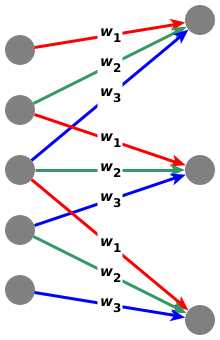

Kernel in the convolutional layer is three dimensional. 

Two first dimensions are its width and height, as discussed above, and the third dimension corresponds to channels.

Original colored image has three channels with clear meaning: red, green and blue colors.

When an image is processed with a single kernel new two dimensional array of pixels is computed, each pixel is a weighted sum of neighboring pixels from all channels.

![convol_3chan.svg](fig/convol_3chan.svg)

Commonly a convolutional layer contains several trainable kernels that are applied simultaneously.

Each kernel results in new two dimensional array and $N$ kernels produce $N$ such arrays. 

![convol_many_chan.svg](fig/convol_many_chan.svg)

Each kernels corresponds to a single neuron. 

So that when multiple kernels are used for convolution there are several neurons that do the same job in parallel: all of them process the whole data sample.


After passing a convolutional layer a number of channels grows. 

### Pooling

Increasing the number of channels due to using many convolutional kernels is important since many kernels, i.e., many convolutional neurons, have more chances to extract essential features from an image. 

This is a sort of competition: multiple convolutional neurons operates in parallel an do the same job. 

But after that we need somehow to take stock and find the winners.

Otherwise our data will inflate. 

So called pooling layers are designed to do this.

Pooling acts on each channel separately, i.e., on the results of each individual convolutional neuron without comparison with others. 

Pooling also has a kernel. The kernel here is mere a window that is moved along an image and a certain aggregation is performed. 

There are two types of pooling: max pooling and average pooling.

Below is the illustration of the max pooling: only the largest values in the window survives and goes further.

In the other words we take the results of each convolutional separately (each channel is a result of one neuron) and find its most successful results only (it means the largest in the local neighborhood).

We remove not the convolutional neurons themselves (remember dropout where the neurons switched out) but their unsuccessful results.

When the average pooling is performed all values within the window are averaged and the result goes to a new layer. 

In the other words we perform smoothing of each channel.

![pooling.svg](fig/pooling.svg)

One more special case of pooling is called global pooling. It corresponds to a window size equal to an the whole image. Only one value survives on each channel - this can be either max or average pooling.

For example assume that a data sample before global pooling had shape (100, 100, 32). It means that there are 32 channels and on each channel there is two dimensional array of size (100, 100).

When the pooling with the kernel size 2x2 is applied the output has the shape (50, 50, 32). 

And after global pooling the shape is (1, 1, 32).

The global pooling is usually applied just one time after all convolutional and local pooling layers.

Basically the global pooling is design to make the network nonsensitive to the input image sizes.

A convolution operates without regarding the image size since we apply the same neuron to each pixel. 

Dense layers on the contrary has a fixed number of inputs so that once created for a certain data sample size they can not be used with another samples: it will be inconsistency in matrix operations.

Usually after convolutional layers there are a couple of dense layers. And to fit this two parts of a network sometimes a global pooling is used that finally removes information about initial sample size. 

### Dropout after convolutional layers

Let us remember: dropout layers are located after dense layers to temporarily switch off several their neurons in course of training. 

This is required to reduces overfitting.

Dropouts between convolutions act totally different. 

It cannot switch off convolutional neurons. All of them are still trained even in the presence of the dropout. 

Instead its influence is more like adding a noise to the network. 

Although sometimes dropout is successfully used in convolution networks, it is better to avoid it: adding a noise to a network can be done in more straightforward way.  

### Typical structure of a network that uses convolutions

In principal there are many ways to combine ideas mentioned above. 

The most simple their implementation is as follows.

Convolutional network includes combinations of the following layers:
- convolution with many kernels: increase number of channels
- pooling: reduce size of an image
- after repeating it several times a global pooling can be applied
- after that the data are flattened and a couple of dense layers are added
- may be dropout can appear in between to reduce overfitting
- on the inner convolutional layers ReLU is often used as activation function
- the network ends with output dense layer whose number of neurons equals to the number of predicted class
- its activation is softmax and the loss function is cross entropy

### Convolutional network for MNIST

Let us now create a network using convolution as described above.

The network will contain the minimal necessary set of layers: convolution followed by max polling, then flatten and the first dense layer, dropout and the final dense layer.

In [ ]:
input_shape = X_train.shape[1:]

dropout_rate = 0.2

model_mnist_D = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda data: data / 256.0, input_shape=input_shape),
    tf.keras.layers.Reshape((*input_shape, 1)),
    tf.keras.layers.Conv2D(4, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(20, activation='relu'), 
    tf.keras.layers.Dropout(rate=dropout_rate), 
    tf.keras.layers.Dense(10) 
])

model_mnist_D.compile(optimizer=tf.keras.optimizers.Adam(),  
                      loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])

model_mnist_D.summary()

In [ ]:
hist_mnist_D = model_mnist_D.fit(X_train, to_categ(y_train), epochs=50, validation_split=0.2, verbose=2)

In [ ]:
plot_hist([hist_mnist_A, hist_mnist_B, hist_mnist_C, hist_mnist_D], 
          ["mnist A", "mnist B", "mnist C", "mnist D"])

In [ ]:
acc, loss = model_mnist_A.evaluate(X_test, to_categ(y_test))
print(f"acc={acc}, loss={loss}")

In [ ]:
acc, loss = model_mnist_B.evaluate(X_test, to_categ(y_test))
print(f"acc={acc}, loss={loss}")

In [ ]:
acc, loss = model_mnist_C.evaluate(X_test, to_categ(y_test))
print(f"acc={acc}, loss={loss}")

In [ ]:
acc, loss = model_mnist_D.evaluate(X_test, to_categ(y_test))
print(f"acc={acc}, loss={loss}")

Observe that even one convolutional layer is able to improve performance. 

Typically networks classifying images has very many such layers.